# Tavsiye Sistemleri
Sizlere **7** adımda marketten aynı anda alınan ürünleri içeren veri seti üzerinden, Support ve Confidence değerlerini yorumlayarak basit tavsiye sistemi geliştirip, aksiyon fikri önereceğim.

* **Support (Destek) :**  X ve Y nin birlikte görülme olasılığı

* **Confidence (Güven):**  X'i alanların yüzde şu kadarı Y'yi de alacak

 ## 1).Veri Okuma

In [ ]:
#https://www.kaggle.com/shazadudwadia/supermarket linkindeki dataseti "Add Data" butonu ile notebookuma dahil ettim. Ardından CSV okuma işlemini gerçekleştiriyorum.

import pandas as pd
df = pd.read_csv('../input/supermarket/GroceryStoreDataSet.csv', names=['products'], header=None)
df

In [ ]:
#DataFrame içerindeki verileri merak ettim, verileri çekiyorum.

df.values

In [ ]:
#Satır ve Sütun bilgisini merak ettim, boyut bilgisine erişiyorum.

df.shape

## 2). Veri Hazırlama

Birliktelik analizinin yapılabilmesi için **Apriori** algoritmasını kullanacağım. 

**mlxtend** kütüphanesinin **apriori** metodu, veri setini **True-False** dataframe olarak kabul etmektedir. 
Veriyi dönüştürmek için yine **mlxtend** kütüphanesinin veriyi dönüştürme metodlarını kullanacağım. 
Bu nedenle elimdeki ham veri setini, bu metodların isteyeceği formata dönüştüreceğim.

In [ ]:
#Adım1 : Veriyi liste formatına dönüştürdüm. Her bir satırdaki objeleri ',' ile ayırdım.

data = list(df["products"].apply(lambda x : x.split(',')))
data

In [ ]:
#Adım2 : mlxtend kütüphanesinin veriyi True-False dataframe ine dönüştürme metodunu uyguluyacağım. 
#İlk önce, kurulu olmayanlar için mlxtend kütüphanesini install ediyorum.

!pip install mlxtend

from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_data = te.fit(data).transform(data)
df = pd.DataFrame(te_data,columns=te.columns_)
df

## 3). Apriori Algoritmasını Uygulama

* Apriori algoritmasının çıktısında, her bir kombinasyonun, tüm veri setindeki frekanslarını elde etmiş oluruz. 
Örneğin aşağıdaki çıktıda sadece "BISCUIT" in tüm veri setinde görülme sıklığı(frekans) 0.35 iken, "BISCUIT ve BREAD" in tüm veri setinde birlikte görülme sıklığı(frekans) 0.20 dir.

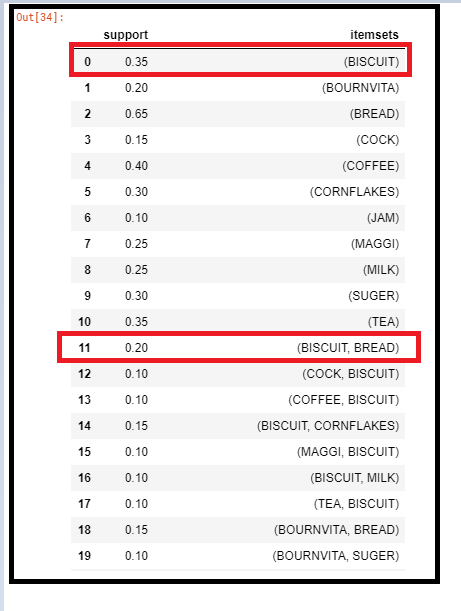

In [ ]:
# Apriori algoritmasına min_support değeri 0.2 verildi. Böylece kombinasyonlardaki 0.2 support değerinin altında olan ürün birliktelikleri elenmiş oldu.
# "verbose" argümanının 1 olması ise toplam kaç kombinasyon olduğu bilgisini bize verecektir. Örneğimizde 42 kombinasyon oluşmuştur. 
# En son durumda ise elimizde 16 kombinasyon kalmıştır. 
# Demek ki 42-16 = 26 kombinasyonumuz 0.2 support değerinin altında kalmış ve yorumlarımıza katmayacağımız önemsiz bir oran olarak ele alınmıştır.

from mlxtend.frequent_patterns import apriori
freq_items = apriori(df,min_support=0.20,use_colnames = True, verbose = 1)
freq_items

##  4). Birliktelik Analizi Uygulama : 
**mlxtend** kütüphanesinin **association_rules** metodu ile support değerleri elimizde olan veri seti kombinasyonuna birliktelik analizi uygulayacağım. 
Son çıktımı "support" ve "confidence" değerlerine göre yorumlayıp örnek bir aksiyon fikri önereceğim

**Örnek Birliktelik Analizi Çıktısı Yorumlama :**
* BISCUIT ve BREAD in birlikte görülme olasılığı **support = 0.20** olduğundan **%20** dir.
* BISCUIT alındığında BREAD alınma olasılığı ise **confidence = 0.571429** olduğundan **%57** civarıdır.

In [ ]:
# "min_threshold = 0.3" verilerek, "confidence" değeri 0.3 altında olan değerlerin getirilmemesi tercih olarak sağlandı.  

from mlxtend.frequent_patterns import association_rules
df_res = association_rules(freq_items, metric = "confidence", min_threshold = 0.3)
df_res

## 5). Veri Filtreleme için Hazırlık

Bu kısımda en düşük, en yüksek confidence değerleri alınarak, bu değerler veri filtrelemede kullanılacak ve aksiyon fikri önerilecektir.

In [ ]:
#En yüksek confidence değerini bulalım. Çıktıda en yüksek confidence değerinin 0.80 olduğu görülüyor.

conf_max = df_res['confidence'].max()
conf_max

In [ ]:
#En düşük confidence değerini bulalım. Çıktıda en düşük confidence değerinin 0.307 olduğu görülüyor.

conf_min = df_res["confidence"].min()
conf_min

## 6). Veri Filtreleme

In [ ]:
#En düşük, En yüksek ve 0.5 confidence değerine sahip olan veriler filtreleniyor. "confidence" değerine göre artan sırada sıralanıyor.

df_filt = df_res[ (df_res["confidence"] == conf_min) | (df_res["confidence"] == conf_max) | (df_res["confidence"] == 0.5 )]
df_filt.sort_values("confidence", ascending = True)

# 7). Yorumlar ve Aksiyon Önerisi
* **MILK       :** Süt
* **BREAD      :** Ekmek
* **COFFEE     :** Kahve
* **CORNFLAKES :** Mısır Gevreği
* **BISCUIT    :** Bisküvi

**Yukarıdaki çıktı baz alındığında;**

  **1. Satır :**<br>
  **a).** Ekmek ve Bisküvinin birlikte alınma olasılığı **support = 0.2** olduğu için **%20**'dir.<br> 
  **b).** Ekmek alındığında Bisküvi alınma olasılığı **confidence = 0.307692** olduğu için **%30**'dur.<br>
  **c).** Bisküvinin tek başına alınma olasılığı **consequent support = 0.35** olduğu için **%35**'tir.
  
  **5. Satır :**<br>
  **a).** Kahve ve Mısır Gevreğinin birlikte alınma olasılığı **support = 0.2** olduğu için **%20**'dir.<br> 
  **b).** Kahve alındığında Mısır Gevreği alınma olasılığı **confidence = 0.5** olduğu için **%50**'dir. 
  
  **7. Satır:**<br>
  **a).** Süt ve Ekmeğin birlikte alınma olasılığı **support = 0.2** olduğu için **%20**'dir.<br> 
  **b).** Süt alındığında Ekmek alınma olasılığı **confidence = 0.8** olduğu için **%80**'dir.
  
### Yorumlar :
* Ekmek alan müşterilerin %30'u Bisküvi de almaktadır. 
* Kahve alınan satışların yarısında Mısır Gevreği de alınmıştır.
* Süt ve Ekmek tüm alışverişlerin %20 sinde birlikte alınmıştır.

### Aksiyon Önerisi :

* Süt alan müşterilerin ekmek alma olasılığı oldukça yüksektir(%80). Bu demek oluyor ki; süt alan müşteriler genelde ekmek de almaktadır ve muhtemelen süt aldıktan sonra ekmek reyonunun yolunu tutacaktır. Süt ve ekmek reyonları market içerisinde birbirinden uzak lokasyonlara konumlandırılarak, süt alan müşterinin ekmek reyonuna giderken, pek çok reyon geçmesi zorunlu kılınabilir. Böylece müşterinin yolculuğu sırasında herhangi bir ürün satın alma olasılığı arttırılabilir.

* Ekmek alan müşterilerin Bisküvi alma olasılığı biraz düşük görünüyor(%30). Bisküvinin tek başına alınma olasılığı da düşük görünüyor(%35). Bisküvi satışını arttırmak için, ekmek rafının hemen yanına bisküvi standı konularak ve fiyatı ucuz olanlar ön plana yerleştirilip, fiyatı koyu etiketle basılarak müşterinin dikkatinin çekilmesi sağlanabilir.